<a href="https://colab.research.google.com/github/adhish-bahl/2347203_NNDL_Lab/blob/main/2347203_Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Importing Libraries**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [16]:
torch.manual_seed(42)

#### **Laoding Dataset**

In [17]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    lambda x: x.view(-1),
    lambda x: x / 255.0
])

cifar10 = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_test = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


#### **Spliting training data into train and validation sets**

In [18]:
train_size = int(0.8 * len(cifar10))
val_size = len(cifar10) - train_size
cifar10_train, cifar10_val = random_split(cifar10, [train_size, val_size])

train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)
test_loader = DataLoader(cifar10_test, batch_size=64, shuffle=False)

#### **Check the data shapes**

In [19]:
input_size = cifar10[0][0].shape[0]
print(f"Input size: {input_size}")

Input size: 1024


#### **Define the RBM Model**

In [20]:
class RBM(torch.nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units

        self.weights = torch.nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)
        self.v_bias = torch.nn.Parameter(torch.zeros(visible_units))
        self.h_bias = torch.nn.Parameter(torch.zeros(hidden_units))

    def sample_h(self, v):
        prob_h = torch.sigmoid(torch.matmul(v, self.weights.t()) + self.h_bias)
        return prob_h, torch.bernoulli(prob_h)

    def sample_v(self, h):
        prob_v = torch.sigmoid(torch.matmul(h, self.weights) + self.v_bias)
        return prob_v, torch.bernoulli(prob_v)

    def forward(self, v):
        _, h_sample = self.sample_h(v)
        _, v_reconstructed = self.sample_v(h_sample)
        return v_reconstructed

    def contrastive_divergence(self, v, k=1):
        v_ = v
        for _ in range(k):
            prob_h, h = self.sample_h(v_)
            prob_v, v_ = self.sample_v(h)
        return v, v_

    def training_step(self, v, k=1):
        v0, vk = self.contrastive_divergence(v, k)
        prob_h0, h0 = self.sample_h(v0)
        prob_hk, hk = self.sample_h(vk)

        positive_grad = torch.matmul(h0.t(), v0)
        negative_grad = torch.matmul(hk.t(), vk)

        self.weights.grad = -(positive_grad - negative_grad) / v.size(0)
        self.v_bias.grad = torch.mean(v0 - vk, dim=0)
        self.h_bias.grad = torch.mean(h0 - hk, dim=0)

        return torch.mean(torch.sum((v0 - vk) ** 2, dim=1))

hidden_units = 128
rbm = RBM(visible_units=input_size, hidden_units=hidden_units)
optimizer = torch.optim.SGD([rbm.weights, rbm.v_bias, rbm.h_bias], lr=0.1)

#### **Train RBM**

In [21]:
epochs = 10
k = 1

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        v, _ = batch
        v = v.view(v.size(0), -1)
        loss = rbm.training_step(v, k)
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 610345.2864
Epoch 2/10, Loss: 637587.1091
Epoch 3/10, Loss: 637587.1074
Epoch 4/10, Loss: 637587.1064
Epoch 5/10, Loss: 637587.1080
Epoch 6/10, Loss: 637587.1072
Epoch 7/10, Loss: 637587.1080
Epoch 8/10, Loss: 637587.1064
Epoch 9/10, Loss: 637587.1060
Epoch 10/10, Loss: 637587.1078


#### **Extract Features**

In [22]:
def get_hidden_representation(data_loader, rbm):
    features, labels = [], []
    for batch in data_loader:
        v, label = batch
        v = v.view(v.size(0), -1)
        prob_h, _ = rbm.sample_h(v)
        features.append(prob_h.detach().numpy())
        labels.append(label.numpy())
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = get_hidden_representation(train_loader, rbm)
test_features, test_labels = get_hidden_representation(test_loader, rbm)

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (40000, 128)
Test features shape: (10000, 128)


#### **Visualize RBM Weights**

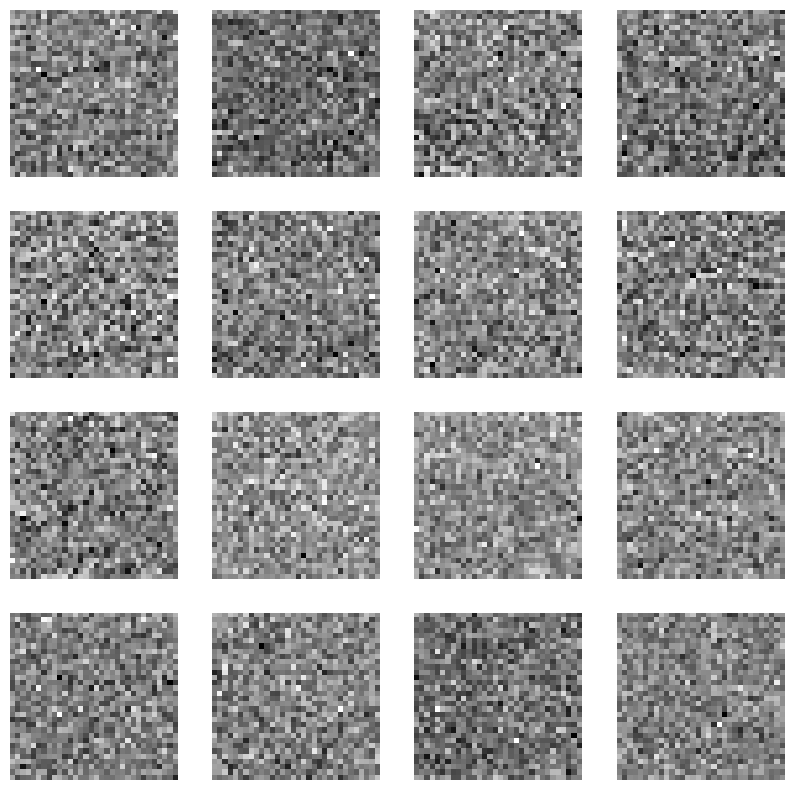

In [23]:
weights = rbm.weights.detach().numpy()
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(weights[i].reshape(32, 32), cmap='gray')
    plt.axis('off')
plt.show()

**Intepretation:**
Each small square corresponds to the weight vector of a single hidden unit reshaped into the original input dimension.

#### **Train and Evaluate Classifier**

In [24]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features, train_labels)

test_preds = classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

Accuracy: 0.1000
F1 Score: 0.0182

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.10      1.00      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Intepretation:**

The output shows poor performance of the classifier trained on RBM-extracted features for the dataset. The overall accuracy is 10%, which is equivalent to random guessing for a 10-class problem. The F1 score is 0.0182, reflecting an imbalance between precision and recall across all classes. F1 scores being 0.00 for most classes. This shows that the RBM has failed to extract meaningful features from the dataset, likely due to inadequate training, hyperparameter tuning.

#### **Analysis**

In [25]:
raw_train, raw_train_labels = next(iter(DataLoader(cifar10_train, batch_size=len(cifar10_train))))
raw_train = raw_train.view(raw_train.size(0), -1).numpy()

raw_test, raw_test_labels = next(iter(DataLoader(cifar10_test, batch_size=len(cifar10_test))))
raw_test = raw_test.view(raw_test.size(0), -1).numpy()

classifier_raw = LogisticRegression(max_iter=1000)
classifier_raw.fit(raw_train, raw_train_labels)

raw_preds = classifier_raw.predict(raw_test)
raw_accuracy = accuracy_score(raw_test_labels, raw_preds)
raw_f1 = f1_score(raw_test_labels, raw_preds, average='weighted')

print(f"Raw Pixel Data - Accuracy: {raw_accuracy:.4f}, F1 Score: {raw_f1:.4f}")

Raw Pixel Data - Accuracy: 0.2412, F1 Score: 0.2106


**Intepretation:**

The classifier trained on the data achieved an accuracy of 24.12% and an F1 score of 0.2106. This performance is very low. This indicates that the data contains more discernible patterns for the classifier to exploit compared to the RBM's extracted features. However, the overall performance remains poor due to the complexity of the dataset, where raw pixel data lacks the hierarchical, abstract representations needed to capture high-level features effectively for classification.